# Supervised Learning Project

## 1. Project Topic: Prediction of Bitcoin hourly price direction 

In this project I will apply various Supervised Learning algorithms on historical Bitcoin price data, with a purpose to find a model for predicting Bitcoin hourly price direction.

The motivation behind this project is to explore how Machine Learning can be used to find patterns in Bitcoin hourly price changes, and then use predictions from ML models as signals in a profitable trading strategy.

The importance of this project implies from the uncommon approach I use for building the models, by taking hourly price changes (in %) other than actual prices, something that I haven't seen in related research papers. My hypothesis is that a series of hourly price changes contain enough information to predict the direction of the next price change (up or down), regardless of the actual prices. The approach and findings can be applied to a broad range of time-series data, not bounded by financial area.

#### 1.1. Algorithms and tasks

I will turn the problem into a **classification task**, by transforming the obtained Bitcoin data into lagged features and a binary decision variable.

I will focus on 3 ML algorithms:

* Logistic Regression
* Decision Tree
* Random Forest

## 2. Data
### 2.1. Data source in APA citation
*Kaggle: Bitcoin_Dataset_(Hourly). Retrieved February 8, 2025 from https://www.kaggle.com/datasets/zackyzac/bitcoin-dataset-hourly, under 
MIT licence: https://www.mit.edu/~amini/LICENSE.md. The data was modified by me for this project according to my needs.*

### 2.2. Data description
The data was downloaded from Kaggle website. It contains 64,375 rows of historical Bitcoin hourly trading details from August 17, 2017, to December 25, 2024, divided into 12 columns. As stated on Kaggle, the data was taken from Binance exchange. Each row corresponds to one hour in the period, and all the rows are consequtive. The columns are:
* Unnamed column tracking row index
* Timestamp - the datetime when the hour started
* Open - the price of Bitcoin at the start of the hour (in USD)
* High - the highest price of Bitcoin during the hour (in USD)
* Low - the lowest price of Bitcoin during the hour (in USD)
* Close - the price of Bitcoin at the end of the hour (in USD)
* Volume - the volume of Bitcoin traded during the hour (in Bitcoin)
* Close_time - the time when the hour ended
* Quote_Asset_Volume - the volume of Bitcoin traded during the hour (in USD)
* Number_of_Trades - the number of trades during the hour
* Taker_Buy_Base_Volume - the volume of Bitcoin bought by takers during the hour (in Bitcoin)
* Taker_Buy_Quote_Volume - the volume of Bitcoin bought by takers during the hour (in USD)
* Ignore - helper field

The following cell will output the type details and memory usage of the dataset.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('btc_data_hourly.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64375 entries, 0 to 64374
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              64375 non-null  int64  
 1   Timestamp               64375 non-null  object 
 2   Open                    64375 non-null  float64
 3   High                    64375 non-null  float64
 4   Low                     64375 non-null  float64
 5   Close                   64375 non-null  float64
 6   Volume                  64375 non-null  float64
 7   Close_Time              64375 non-null  int64  
 8   Quote_Asset_Volume      64375 non-null  float64
 9   Number_of_Trades        64375 non-null  int64  
 10  Taker_Buy_Base_Volume   64375 non-null  float64
 11  Taker_Buy_Quote_Volume  64375 non-null  float64
 12  Ignore                  64375 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 6.4+ MB


To get an idea of how the data looks like, I will output the first 5 rows:

In [21]:
data.head(5)

,Unnamed: 0,Timestamp,Open,High,Low,Close,Volume,Close_Time,Quote_Asset_Volume,Number_of_Trades,Taker_Buy_Base_Volume,Taker_Buy_Quote_Volume,Ignore
0,0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,0
1,1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,0
2,2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,0
3,3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,0
4,4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,0


## 3. Data Cleaning

In this section I will perform the following data-cleaning operations: removing unneeded features, dropping rows with null cells, clipping values to specific thresholds, analysing and removing rows that can break the sequencial order of the data.

Along with the data-cleaning I will perform a few feature-engineering operations to transform the data to my needs. I decided to include these transformation in this section as both types of operations are interwined and complement each other. The result of this section will be a clean and transformed dataset, ready for a clasification task.

### 3.1. Creating the lagged features
*Lagged features are a result of a feature-engineering technique which takes data from previous time points and includes it in current time point (https://en.wikipedia.org/wiki/Distributed_lag)*

The central idea of my approach is to create the lagged features from hourly price changes and not from the price itself. To achieve that I will use the pct_change() method to calculate the price change (in %) between a current row and a previous row, and then add 10 last price changes to each row as features. I chose to use the Close price for these calculations:

In [23]:
# Using pct_change() to calculate the percentage change in the 'Close' column between the current and the 
# previous row and storing the result in a 'price_change' column. Performed for each row.
data['price_change'] = data['Close'].pct_change() * 100

# Creating 10 lagged features for the 'price_change' column. This will represent the last 10 hours of price changes.
# The shift() function is used to shift the values of the 'price_change' column by 1 to 10 rows.
# The columns will be named 'pc_1' to 'pc_10', where 'pc_10' will represent the price change of the previous hour
# and 'pc_1' will represent the price change of the 10th hour before the current hour. 
for i in range(1, 11):
    data[f'pc_{11 - i}'] = data['price_change'].shift(i)

# Displaying the first 10 rows to see the new columns
data[['Timestamp', 'Close', 'price_change', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10']].head(10)

,Timestamp,Close,price_change,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10
0,2017-08-17 04:00:00,4308.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-17 05:00:00,4315.32,0.150621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-17 06:00:00,4324.35,0.209254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150621
3,2017-08-17 07:00:00,4349.99,0.592921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150621,0.209254
4,2017-08-17 08:00:00,4360.69,0.245978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150621,0.209254,0.592921
5,2017-08-17 09:00:00,4444.00,1.910477,NaN,NaN,NaN,NaN,NaN,NaN,0.150621,0.209254,0.592921,0.245978
6,2017-08-17 10:00:00,4460.00,0.360036,NaN,NaN,NaN,NaN,NaN,0.150621,0.209254,0.592921,0.245978,1.910477
7,2017-08-17 11:00:00,4427.30,-0.733184,NaN,NaN,NaN,NaN,0.150621,0.209254,0.592921,0.245978,1.910477,0.360036
8,2017-08-17 12:00:00,4411.00,-0.368170,NaN,NaN,NaN,0.150621,0.209254,0.592921,0.245978,1.910477,0.360036,-0.733184
9,2017-08-17 13:00:00,4459.00,1.088189,NaN,NaN,0.150621,0.209254,0.592921,0.245978,1.910477,0.360036,-0.733184,-0.368170


### 3.2. Determining the "corrupted" rows
To ensure the lagged features in each row are sequential and refer to 10 last hours of price changes, I will check that Close_Time in each row is exactly 1 hour after the Close_Time in the previous row:

In [24]:
# I will collect indices of rows which differ by more than 1 hour from a previous row
corrupted_indices = []

# Looping through the data and checking if the difference between the current row and the previous row is exactly 1 hour
# The Close_Time is in milliseconds, so 1 hours is 3600000 milliseconds
for i in range(1, len(data)):
    if (data['Close_Time'].iloc[i] - data['Close_Time'].iloc[i - 1]) != 3600000:
        corrupted_indices.append(i)

print('Number of corrupted rows:', len(corrupted_indices))


Number of corrupted rows: 45


There are 45 "corrupted" rows in the data that need to be removed. In addition, I will need to remove 10 rows following each corrupted row, as the corrupted data is propagated to 10 following rows as a lagged feature:

In [25]:
# Removing each corrupted row and 10 following rows. Looping in reverse order to avoid index shifting after rows removal
for i in range(len(corrupted_indices)-1, -1, -1):
    data.drop(data.index[corrupted_indices[i]:corrupted_indices[i]+11], inplace=True)

### 3.3. Additional cleaning and arranging of the data
In the next cell I will perform addition cleaning and arranging steps. I will comment each step:

In [26]:
# Drop rows with NaN values
data.dropna(inplace=True)

# Reseting the index
data.reset_index(drop=True, inplace=True)

# I will keep the prices and price_change in separate lists for later use
prices = data['Close']
price_changes = data['price_change']

# Droping the unnamed column
data.drop(data.columns[0], axis=1, inplace=True)

# Droping all other unneded columns
data.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_Time', 'Quote_Asset_Volume', 'Number_of_Trades', 'Taker_Buy_Base_Volume', 'Taker_Buy_Quote_Volume', 'Ignore'], axis=1, inplace=True)

# Flip columns so that the most recent price change is the last column
data = data.iloc[:, ::-1]

### 3.4. Creating the decision variable
To make the dataset ready for a classification task, I will need to create a decision variable, the price_direction column. To fill this column, I will check the price_change for each row. If price_change is positive, the price_direction will be 1. Otherwise it will be 0. This simply means that if Close price in current row is higher than Close price in previous row, I will classify this case as 1, and otherwise as 0:

In [27]:
# Decision variable
data['price_direction'] = np.where(data['price_change'] < 0, 0, 1)
data.drop('price_change', axis=1, inplace=True)

### 3.5. Checking for imbalance

I will visualise the distribution of the decision variable, and print the percentages, to see if it is balanced:

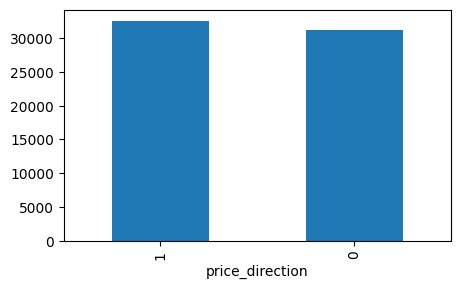

price_direction
1    0.510326
0    0.489674
Name: proportion, dtype: float64

In [29]:
plt.figure(figsize=(5, 3))
data['price_direction'].value_counts().plot(kind='bar')
plt.show()

# percentages
data['price_direction'].value_counts(normalize=True)


The distribution of the decision variable is slighly inbalanced. Class 1 accounts for 51% of the rows and class 0 for 49%. I do not need to correct this now, but I will address this when I build the models.

### 3.6. Checking for outliers
I will check if there are outliners in lagged features. For that I will plot the histogram of the data and print out the number of values above specific thresholds (using absolute values). I chose a single feature for this analysis (pc_10) as all features represent the same variable (price change), just in different time points.

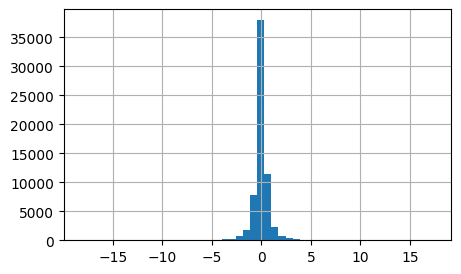

Number of absolute values above 0: 63869
Number of absolute values above 1: 7272
Number of absolute values above 2: 2012
Number of absolute values above 3: 747
Number of absolute values above 4: 320
Number of absolute values above 5: 166
Number of absolute values above 6: 97
Number of absolute values above 7: 55


In [30]:
# Histogram of pc_10
plt.figure(figsize=(5, 3))
data['pc_10'].hist(bins=50)
plt.show()

for i in range(8):
    print(f'Number of absolute values above {i}:', len(data[data['pc_10'].abs() >= i]))


From the above figures I see that 99% of the data is concentrated between -3 and +3. After a few trials with the models, I decided to clip the data on -5 and 5. This means any value below -5 will be changed to -5 and any value above 5 will be changed to 5. Hovewer, I must note, that clipping the data has a very small effect on the perormance of the models.

I also want to mention that I did not consider removing the outlier rows completely, because this will affect the sequential order of the lagged features of the following rows.

In [31]:
# Clipping the data of each cell to be between -5% and 5%
data = data.clip(-5, 5)

### 3.6. Data Cleaning Summary and Discussion

After performing the Data Cleaning and Feature Engineering my data is now clean and ready for the analysis. I will mention again that I had to transform the original data into 10 lagged features and the decision variable, to make it ready for a clasification task. The choise of number 10 for the lagged features is an initial guess, and I will address this in later sections when analysing feature importance. I intentionally removed all the original features and didn't add any new ones (except the lagged features), in order to test my hypothesis that the price direction can be predicted with good accuracy only by looking into price changes of the last few hours.

From Data Cleaning perspective I had a few very basic steps, like removing rows with NaN or removing original features, but also a more challenging task of finding the rows which can break the sequential order of data. I must say that Bitcoin data made my work much simpler, because the trade is continuos, 24/7. I didn't need to account for weekends or holidays or daily trading hours.

So now, I can be sure that each row in my final dataset represents the price changes in 10 consequtive hours and a direction of the price in the next hour.

I will print the first 5 rows of the data:

In [32]:
data.head(5)

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,price_direction
0,0.150621,0.209254,0.592921,0.245978,1.910477,0.360036,-0.733184,-0.368170,1.088189,0.265082,0
1,0.209254,0.592921,0.245978,1.910477,0.360036,-0.733184,-0.368170,1.088189,0.265082,-2.650073,1
2,0.592921,0.245978,1.910477,0.360036,-0.733184,-0.368170,1.088189,0.265082,-2.650073,0.042276,0
3,0.245978,1.910477,0.360036,-0.733184,-0.368170,1.088189,0.265082,-2.650073,0.042276,-1.491440,0
4,1.910477,0.360036,-0.733184,-0.368170,1.088189,0.265082,-2.650073,0.042276,-1.491440,-0.752348,1


To get more understanding of how each row relates to original prices, I will plot an example of a random row and below the corresponding prices:

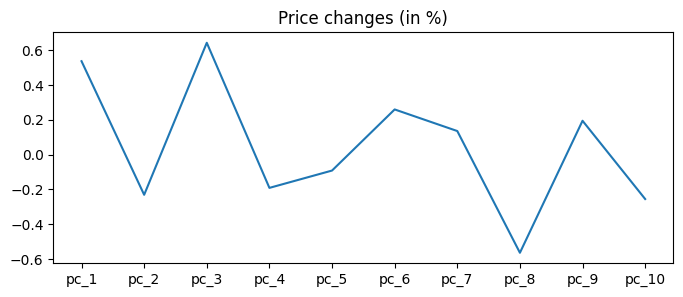

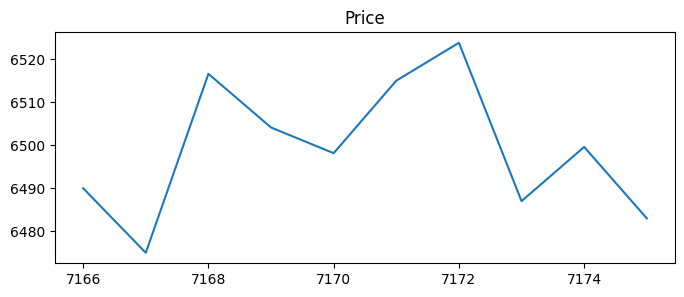

In [33]:
i = np.random.randint(0, len(data))

plt.figure(figsize=(8, 3))
plt.plot(data.iloc[i+10][:10])
plt.title('Price changes (in %)')
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(prices.iloc[i:i+10])
plt.title('Price')
plt.show()

## 4. Exploratory Data Analysis
In this section I will focus on 4 areas: the general features analysis, the histogram of the price changes, the distribution of the decision variable, and the correlation matrix. For each part I will include visualzation, analysis and discussion.

### 4.1. General features analysis
I will plot 6 random rows of the data (only the features) to get some intuition of what the data represents. I will use the bar charts this time:

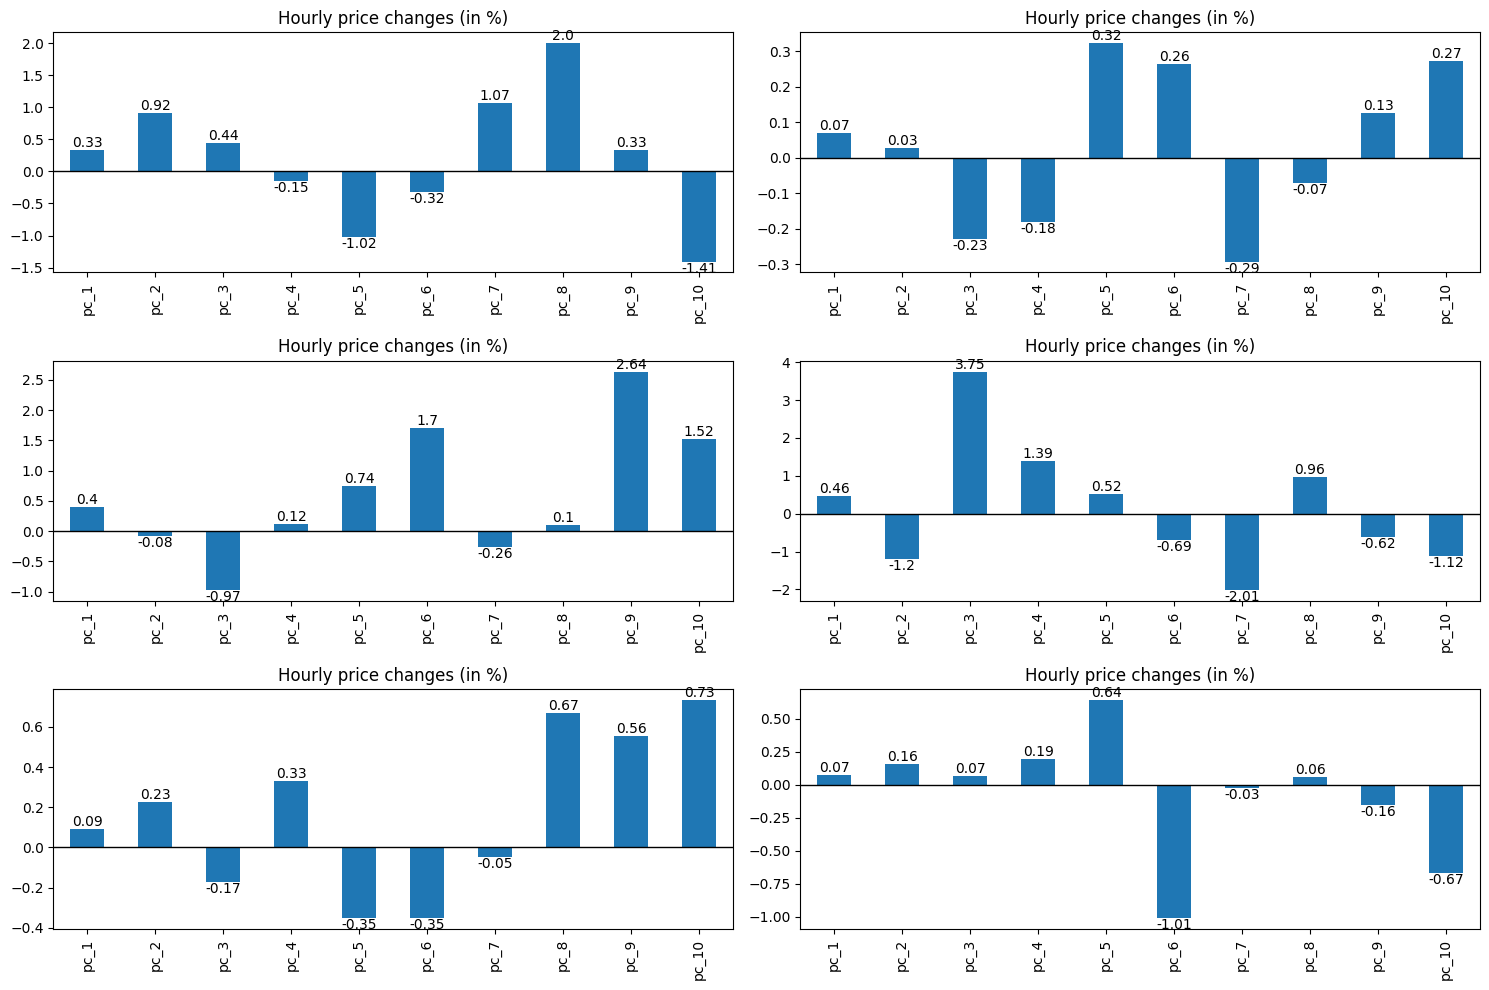

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for ax in axes.flatten():
    i = np.random.randint(0, len(data))
    plot = data.iloc[i+10][:10].plot(kind='bar', ax=ax)
    plot.set_title('Hourly price changes (in %)')
    plot.axhline(0, color='black', lw=1)
    for index, value in enumerate(data.iloc[i+10][:10]):
        text_loc = 'bottom' if value > 0 else 'top'
        plot.text(index, value, str(round(value, 2)), ha='center', va=text_loc)

plt.tight_layout()
plt.show()

By looking at the above graphs, it becomes obvious that it's possible to reconstruct the actual prices of Bitcoin, if we knew what was the price 1 hour before each graph's period. And the advantage of my approach is that the actual price is not needed for predicting the direction, as the relative price changes already capture all the information about the dynamics of the price.

Another important point is that there is no need to normalize the data, because the values only indicate the change, regardless the price.



### 4.2. Histogram of price changes
I will plot the histogram again:

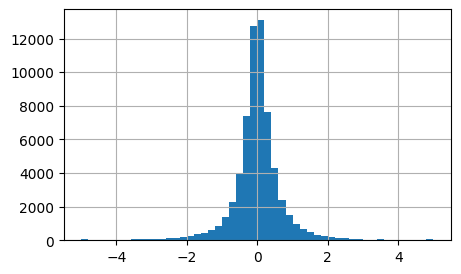

In [35]:
plt.figure(figsize=(5, 3))
data['pc_10'].hist(bins=50)
plt.show()

The above histogram indicates that price changes are distributed with a good symetry around 0, with much higher density when approaching 0 from both sides. This means that most of the price changes are very small. This also gives more understanding about the chosen decision variable. It will classify the change as '1', regardless if it's a 0.01% increase or 3.5% increase.

While doing an initial trials with the data I did try to split the classification to more classes, but the accuracy for such models is much lower. Therefore, I decided to keep it simple for this project and have only 0 and 1 classes.

### 4.3 Distribution of the decision variable
Next, I will examine the imbalance of the decision variable. In the Data Cleaning section I saw that 51% of the rows classify as 1. Here, I will do a more thorough analysis and plot the 1s percentage across the whole data in a rolling window of 5000. That means each point in the graph will show the percentage of 1s across 5000 rows preceding that point. Given the classes are 0 and 1, the percentage of 1s is simply the mean value:

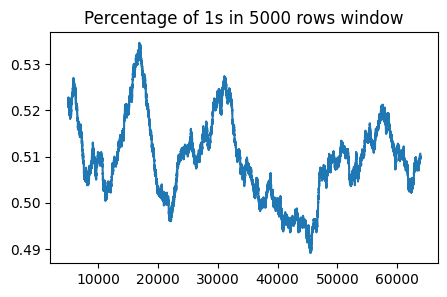

In [36]:
# plot the percentage of 1s in 10 regions of the data
plt.figure(figsize=(5, 3))
data['price_direction'].rolling(window=5000).mean().plot()
plt.title('Percentage of 1s in 5000 rows window')
plt.show()


The above graph shows that distribution of 1s is not equal over the time. In some regions the percentage of 1s is over 53%, while in others it is below 49%. This is an important observation which will influence my choise of train and test data. I will not be able to alocate a specific region for train and test data as the distribution of classes is different accross regions. I will address this in the Models section and present a solution.

### 4.4. Correlation matrix
Finally, I will plot the correlation matrix of the 10 features:

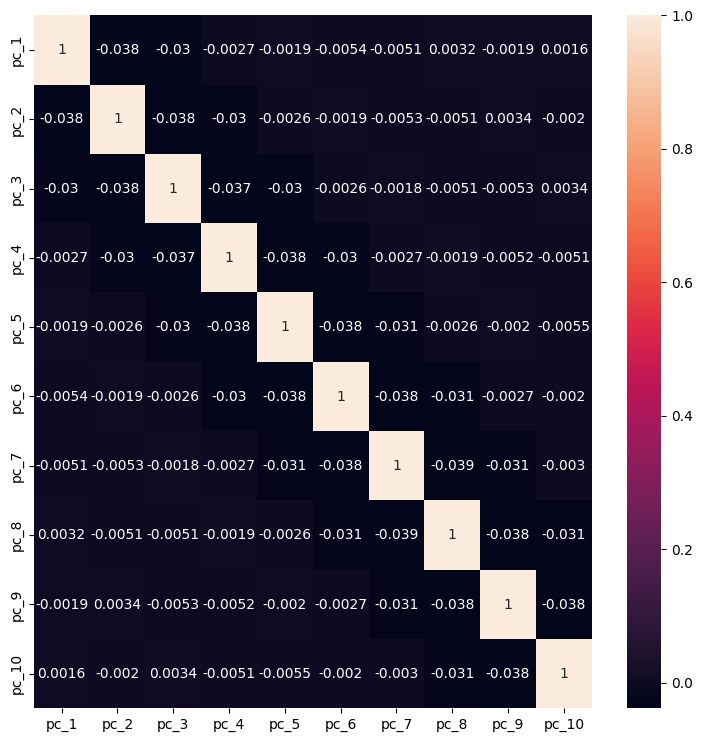

In [37]:
import seaborn as sns

plt.figure(figsize=(9, 9))
sns.heatmap(data.iloc[:, :-1].corr(), annot=True)
plt.show()



From a first look on the above graph, it seems like the features are not correlated at all. But then, taking into account the nature of the data, the slight 4.5% correlation between 2 adjacent features and 3% correlation between features which are 2 hours apart, can be an interesting insight. That can suggest that the price changes are not completely random, and have a slight influence from previous price changes.

I will also need to take the correlation into account when building the model, to make sure it doesn't have a negative effect on the performance.

### 4.5. Summary, conclusion, and foreseen difficulties
The EDA of the 4 selected areas gave me a good sense of the data, and a few interesting findings (I discussed them separately in each part). Probably the most important, is that the distribution of the decision variable (section 4.3) has a big variance across different regions (time periods) of the data. This will help me with choosing the right approach for the train/test split.

The foreseen difficulty is probably related to a very thin difference between negative and positive values in the near-zero region. The values can be very close, but still be classified to different classes only because they differ in sign. I will discuss the idea of how to overcome this in the actual application of the models, when I'll build a trading strategy. This is related to the confidence of the prediction.

## 5. Models
In this section I will create **multiple models**, namely Logistic Regression, Decision Tree and Random Forest. For each model I will only print out the accuracy, leaving the more detailed discussion on performance to Results and Analysis section.

I will apply **cross validation** for all the models, and **hyperparameters tuning** for Random Forest.

I also used **features engineering**, which is in the list of requirements for this section, but I aready included it in section 3.1, as it was part of the data transformation.

### 5.1. Train and test data
As I mentioned in the previos section, I cannot just allocate a specific region in my data for train and test purposes, because of the varying decision variable distribution. To solve that, I will use the whole dataset for the train_test_split() function and define the test_size to be 0.9. That feels counterintuitive at first glance, but in my case it serves the purpose. Indeed, I will have the train set to be 10% of the whole data, but it will be randomly chosen across the whole time period. The test set, on the other hand, will be 90% of the data, and also spread across the whole period. The huge test set will allow me to evaluate my models on the whole period, and avoid the bias of focusing on specific timeframe.

Another reason of making the train set to be as low as 10% of the data is related to the simulation of a trading strategy. I will need to skip all train-set points in the simulation, but still have anough data to run my strategy for the whole timeframe of the data. So having 90% of the data for this purpose will allow me to evaluate my trading strategy with unseen data accross the entire period.

In [38]:
from sklearn.model_selection import train_test_split 

X = data[['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10']]
y = data['price_direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=15)


### 5.2. Logistic Regression
My first model is Logistic regression. I will add "class_weight='balanced'" parameter (I will add it to all other models as well) to account for a slight imbalance in the decision variable.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5376720073760938


### 5.3 Desicion Tree
For the Decision Tree I will use max_depth of 8, which seems reasonable guess given the number of features


In [41]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(max_depth=8, class_weight='balanced')
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5254075117860932


### 5.5. Hyperparameter tuning
I will use GridSearchCV to find the best hyperparameters for the Random Forest model. It takes much time to run this cell, so the code is commented out. Feel free to uncomment and run.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier()
model3.fit(X_train, y_train)

param_grid = {
    'n_estimators': [140, 150, 160],
    'max_depth': [7, 8, 9],
    'min_samples_split': [10, 11, 12],
}

grid_search = GridSearchCV(model3, param_grid, scoring='f1')

#grid_search.fit(X_train, y_train)

#print(f"Best parameters: {grid_search.best_params_}")
#print(f"Best score: {grid_search.best_score_}")

#model3 = grid_search.best_estimator_

### 5.4. Random Forest
For the Random Forest I will use n_estimators=150, max_depth=8, and min_samples_split=11. These parameters were chosen after running the GridSearchCV optimization in the previous cell.

In [43]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(n_estimators=150, max_depth=8, class_weight='balanced', min_samples_split=11, random_state=22)
model3.fit(X_train, y_train)

y_pred3 = model3.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred3)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5441956752431154


### 5.6. Cross validation
I will apply cross validation to all 3 models to see how the models perform across different time regions of the data. For that I will use the entire dataset and choose 6 folds, which means around 10000 samples in each fold.

In [44]:
# Cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model1, X_test, y_test, cv=6)
print(f"Cross validation for Logistic Regression scores: {scores}", "mean:", scores.mean())

scores = cross_val_score(model2, X_test, y_test, cv=6)
print(f"Cross validation for Decision Tree scores: {scores}", "mean:", scores.mean())

scores = cross_val_score(model3, X_test, y_test, cv=6)
print(f"Cross validation for Random Forest scores: {scores}", "mean:", scores.mean())


Cross validation for Logistic Regression scores: [0.54482831 0.55098633 0.54420207 0.55375783 0.54665971 0.54864301] mean: 0.5481795404192812
Cross validation for Decision Tree scores: [0.53741781 0.53700031 0.53292976 0.53695198 0.54008351 0.5408142 ] mean: 0.5375329271420319
Cross validation for Random Forest scores: [0.54889886 0.54942073 0.54482831 0.54707724 0.54634656 0.55615866] mean: 0.5487883933907989


The scores across different folds look very similar for all models, which means the models generalize well for different periods of the data.

## 6. Results and Analysis
This section will include 3 parts: summary of the results and discussion, evaluating the models by their performance in a trading strategy (different evaluation metrics), visualization of models performance in a trading strategy, and a discussion about models performance.


### 6.1 Performance results summary and discussion
To explore and compare the performance of the models I will user the classification_report() method:

In [57]:
# compare classification reports
from sklearn.metrics import classification_report

print("Logistic Regression:")
print(classification_report(y_test, y_pred1))

print("Decision Tree:")
print(classification_report(y_test, y_pred2))

print("Random Forest:")
print(classification_report(y_test, y_pred3))



Logistic Regression:
              precision    recall  f1-score   support

           0       0.53      0.54      0.53     28126
           1       0.55      0.54      0.54     29357

    accuracy                           0.54     57483
   macro avg       0.54      0.54      0.54     57483
weighted avg       0.54      0.54      0.54     57483

Decision Tree:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48     28126
           1       0.53      0.60      0.56     29357

    accuracy                           0.53     57483
   macro avg       0.52      0.52      0.52     57483
weighted avg       0.52      0.53      0.52     57483

Random Forest:
              precision    recall  f1-score   support

           0       0.54      0.50      0.51     28126
           1       0.55      0.59      0.57     29357

    accuracy                           0.54     57483
   macro avg       0.54      0.54      0.54     57483
weighted avg       0.54

The above summary of the performance of the 3 models may look disastrous at first glance. An accuracy of 0.53-0.54 is only a small improvement over a random choice. However, after researching the web and reading more papers on the subject, I understood that even the best models in high-frequency trading companies or hedge funds do not usually reach an accuracy of above 0.55-0.6 for this kind of price predictions. An accuracy of 0.54 means that long term trading strategy based on signals from a corresponding model can be profitable. It is like playing against a casino with 54% chances to win.

But there is more on that. The evaluation of the model doesn't have to be only by accuracy. It actually depends on how the model will be applied in the real world. In my case, the goal is to use the model for trading strategy. And for that, I can choose to only consider the predictions of the '1' class, which means the upward direction of the price in the next hour. With that, I will be more interested in the precision of '1' class in my models, which is 0.55 in Logistic Regression and Random Forest. I can also consider the f1 metric for the '1' class, for which the Random Forest leads with 0.57. However I cannot know for sure which metric or model is the best before actually using it in a trading strategy.

### 6.2. The trading strategy
The idea behind ML-based trading strategies is to use model predictions as signals for making trade decisions (buy/sell/hold).

I will implement a very basic strategy, which will buy Bitcoins when the prediction is up (class '1') and sell after one hour regardless of the price. This mean if the prediction is correct and the price went up, the operation will result in a profit, which is equal to the amount of the trade (30,000 USD in my case) multiplied by the price change percentage of that hour. If the price went down, it will be a loss, with a similar calculation.

I will use all the 3 models for predictions and simulate the strategy on the whole period of Bitcoin data, from August 17, 2017, to December 25, 2024. I will track the number of total trades and number of profitable trades, and see the actual accuracy of the strategy. And I will track the cumulative return (profit), to compare the performance of the models.

In addition to the 3 models I will have a 'random choice' model, where prediction is simply random.

And finally, to increase the accuracy of the profitable trades, I will use the predict_proba() instead of the actual prediction, which corresponds to the confidence of the model regarding specific prediction.

The code for the trading strategy is below:

In [57]:
# this amount was chosen to make the returns comparable for the Bitcoin price. It can be any other amount.
single_trade_amount = 30000

# Models
models = [
    {
        'name': 'Random Trading', 
        'predicted_class': np.random.rand(len(data), 2),
        'cumulative_return': [0], 
        'number_of_trades': 0,
        'wins': 0
    },
    {
        'name': 'Logistic Regression', 
        'predicted_class': model1.predict_proba(X),
        'cumulative_return': [0], 
        'number_of_trades': 0,
        'wins': 0
    },
    {
        'name': 'Decision Tree', 
        'predicted_class': model2.predict_proba(X), 
        'cumulative_return': [0], 
        'number_of_trades': 0,
        'wins': 0
    },
    {
        'name': 'Random Forest', 
        'predicted_class': model3.predict_proba(X), 
        'cumulative_return': [0], 
        'number_of_trades': 0,
        'wins': 0
    }
]

# Run the trading strategy over the whole dataset for each model
for i in range(1, len(data)):
    for model in models:
        # Skip train data. This is an important step, to avoid higher accuracy for data that was used to train the model
        if i in X_train.index:
            model['cumulative_return'].append(model['cumulative_return'][-1])
            continue

        # Buy if the probability of the price going up is higher than 54%.
        # This threshold was chosen after some testing.
        if model['predicted_class'][i][1] > 0.54:
            model['cumulative_return'].append(model['cumulative_return'][-1] + (single_trade_amount * (price_changes[i] / 100)))
            model['number_of_trades'] += 1
            if price_changes[i] > 0:
                model['wins'] += 1
        else:
            model['cumulative_return'].append(model['cumulative_return'][-1])
            

# Results
for model in models:
    print(model['name'])
    print("- number of trades:", model['number_of_trades'])
    print("- accuracy:", round(model['wins'] / (model['number_of_trades']), 3))
    print("- cumulative return:", round(model['cumulative_return'][-1], 2), "\n")

Random Trading
- number of trades: 26412
- accuracy: 0.508
- cumulative return: 31050.93 

Logistic Regression
- number of trades: 4831
- accuracy: 0.575
- cumulative return: 123453.21 

Decision Tree
- number of trades: 21668
- accuracy: 0.554
- cumulative return: 147069.37 

Random Forest
- number of trades: 15337
- accuracy: 0.573
- cumulative return: 194502.91 



By looking at the above results, it can be seen that the models are much more accurate when used in a trading strategy. The reason for that is because I used it to only predict the upward direction (class '1'), and also because I used the predict_proba() confidence threshold of 54%. The accuracy of Random Forest and Logistic Regression increased to 0.57. The Random Forest performance however was much better because the number of trades was much higher, which resulted in higher returns.

### 6.4. Visualization of the trading strategy performance

To have more understading of the performance I plotted the cumulative returns of the models over time, alongside the Bitcoin price:

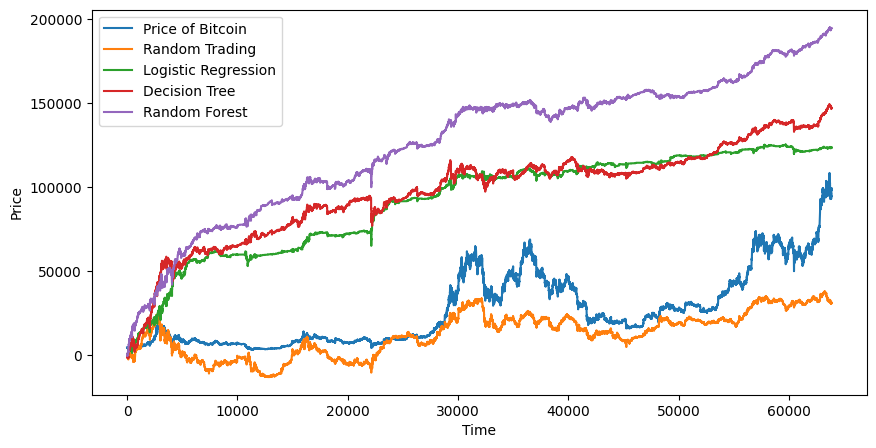

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, prices, label='Price of Bitcoin')
for model in models:
    plt.plot(data.index, model['cumulative_return'], label=model['name'])

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### 6.5. Analysing the performance and discussion
The graph gives much more insights on the performance, as it shows the profits trend. The Random Choise strategy doesn't have a stable trend, and the profits are completely unpredictable at the end of the period on each run. However, the 3 ML models all have a quite stable rising trend and perform well even during periods when Bitcoin price goes down. The Random Forest has a significantly better performance. The actual final return is not so important, as it depends on the trade amounts. But the consistently increasing profit over time - that is the real good metric for model performance and a good example how 55-60% accuracy can be utilized to make profits.

I must add, that while this strategy can work in theory, there are many more factors to consider in real trading. The most significant one is the trasaction fee or the spread between buy/sell price, which can wipe out most of the profits and result in big losses. Adapting the strategy to real world conditions is a much more complicated challenge.

## Discussion and conclusion

#### Why the accuracy of the models is so low?
The price of Bitcoin is not influenced only by a history of it's price in the last 10 hours. Thousands of buy/sell orders are placed every second in Market Exchanges and the price is set by sellers and buyers based on their expectations, news, other markets and many other factors. It is obvious that models which are only based on lagged features cannot capture all these factors.

#### Learnings and takeway
I learned an important insight, that Bitcoin hourly price changes are not a pure random figures, but have some underlying patterns that can be captured by Machine Learning Algorithms. The nature of these patterns is not clear to me yet, but I suppose it is a combination of traders behaviour, news, and other factors, which altogether result in 54-55% prediction accuracy. It is interesting that this accuracy is consistent, more or less, across different models and different periods in time.

The main takeway from this project is that even a model with a slightly better performance than random choice, can be used in a profitable trading strategy for predicting Bitcoin price direction (or for any other financial asset). A valuable observation for me was that finding and optimizing a model is only one part of a successful ML project. Another part is actually finding the right way to apply the model to real world scenarios (in my case the trading strategy) and using it for decision making. That's where an apparently weak model can turn into a strong tool. In my case it was the choise to use only one class of decision variable (price goes up) and using predicted_proba instead of predicted class to set the threshold for the decision. This approach increased the accuracy of the trading strategy to 57%.

#### Ways to improve
While working on this project I had a lot of ideas for improvements. The most important is probably adding more features, like other cryptocurrencies' prices, stock market indices, gold and oil prices, trade volumes, news indicators, moving averages and a lot of others. I also look forward to exploring other models, like Neural Networks. Another improvement idea is to combine several models in one strategy, for example using a combined signal from all 3 models or adding models with different time windows (like 4-hour prices, or daily prices).

From my short experience through this project I understood that the possibilities to improve a model are limitless. What's important to remember is that there are many players in this field, some of them are big algo-trading companies, and many of them are exploring the market and look for profitable strategies. When a pattern is found in the data, it will be quickly exploited and the market will adapt, turning the pattern into obsolete. Therefore, it should be a continuous process of iterating and improving the existing models, monitoring the performance on new data, and quickly adapting to new market conditions.

**********

*Important note: My interest in this topic is purely academic. The findings in this project are not verified and should not be considered as a trading advice. Financial markets are volatile and risky, and I would strongly advise to avoid any speculative trading activity completely.*